# Tutorial explaining the use of different emulators, from different archives

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator
from lace.utils import poly_p1d

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


## CREATE TRAINING AND TESTING ARCHIVE (Gadget)

In [3]:
# list of emulator parameters used with Gadget sims
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

In [4]:
archive = gadget_archive.GadgetArchive(postproc="Cabayol23")
training_data=archive.get_training_data(emu_params=emu_params)
len(training_data)

9900

In [5]:
testing_data = archive.get_testing_data(sim_label='mpg_central')
len(testing_data)

11

In [6]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

## NEURAL NETWORK EMULATOR  

Some of the cells in this notebooks can be quite slow, so we only run them if thorough==True

In [8]:
thorough=False

### Example 1: We can train a custom emulator... 

#### A. passing a custom archive:

In [9]:
emulator = NNEmulator(archive=archive, nepochs=1)

Use custom archive provided by the user to train emulator
Training samples in archive : 9900
Selected custom emulator
Training NN on 9900 points
NN optimised in 0.5198490619659424 seconds


### or a training_set label

In [10]:
emulator = NNEmulator(training_set='Cabayol23',nepochs=1)

Training emulator Cabayol23
Selected custom emulator
Training NN on 9900 points
NN optimised in 0.2158036231994629 seconds


#### If none or both are provided, the emulator fails. 

In [11]:
emulator = NNEmulator(nepochs=1)

ValueError: Archive or training_set must be provided

### Example 2: We can train a pre defined emulator... 

#### A. with a training_set label

In [12]:
emulator = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23', nepochs=1)

Training emulator Cabayol23
Selected emulator Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training NN on 9900 points
NN optimised in 23.357277154922485 seconds


#### B. with an archive

In [13]:
emulator = NNEmulator(archive=archive, emulator_label='Cabayol23', nepochs=1)

Use custom archive provided by the user to train emulator
Training samples in archive : 9900
Selected emulator Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training NN on 9900 points
NN optimised in 45.30361318588257 seconds


#### If none are provided, the training fails

In [14]:
emulator = NNEmulator(emulator_label='Cabayol23', nepochs=1)

ValueError: Archive or training_set must be provided

### Example 3: Load a pre-trained emulator, providing the path of the saved network parameters

Training emulator Cabayol23
Samples in training_set: 9900
Selected emulator Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed
CPU times: user 10.9 s, sys: 243 ms, total: 11.2 s
Wall time: 11.2 s


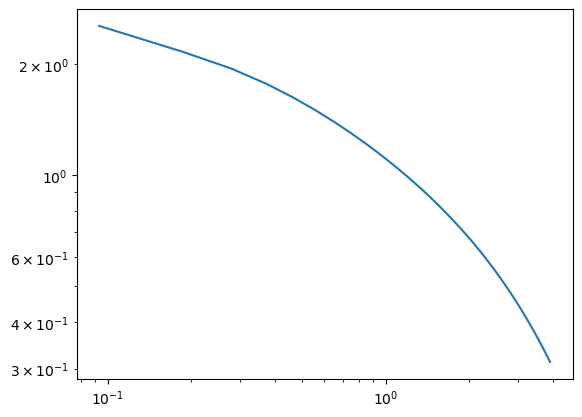

In [7]:
%%time
emulator = NNEmulator(
    training_set='Cabayol23',
    emulator_label='Cabayol23',
    model_path='NNmodels/Cabayol23/Cabayol23.pt', 
    train=False
)
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0], kMpc)
plt.loglog(kMpc,p1d)

## GAUSSIAN PROCESS EMULATOR

## The Gaussian process emulator uses the following default parameters:

- paramList=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- kmax_Mpc=10
- ndeg=4

### Example 1: Train custom emulator 

#### with a defined training_set

In [8]:
emulator = GPEmulator(training_set='Pedersen21')

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points


 /home/jchaves/miniconda3/envs/py11/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.58 seconds


#### with a custom archive

In [9]:
emulator = GPEmulator(archive=archive)

Use custom archive provided by the user
Selected custom emulator
Training GP on 330 points
GPs optimised in 0.52 seconds


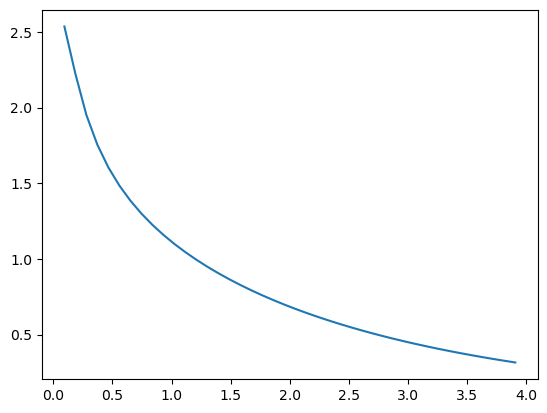

In [10]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

### Example 2: Pre-defined GP emulators:

In [11]:
emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

Selected training set from Pedersen21
Select emulator in Pedersen21
Gaussian Process emulator predicting the P1D at each k-bin. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones.
Training GP on 330 points
GPs optimised in 1.18 seconds


In [12]:
emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

Selected training set from Pedersen21
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.47 seconds


## LaCE-Nyx emulator (NN)

In [14]:
# emulators will use different emulator parameters depending on the archive
nyx_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

In [16]:
# you could specify here the path to the Nyx files, or set a NYX_PATH variable
archive = nyx_archive.NyxArchive(verbose=True)

read Nyx sim bar_ic_grid_3
read Nyx sim cosmo_grid_0
read Nyx sim cosmo_grid_1
read Nyx sim cosmo_grid_10
read Nyx sim cosmo_grid_11
read Nyx sim cosmo_grid_12
read Nyx sim cosmo_grid_13
read Nyx sim cosmo_grid_15
read Nyx sim cosmo_grid_16
read Nyx sim cosmo_grid_17
read Nyx sim cosmo_grid_2
read Nyx sim cosmo_grid_3
read Nyx sim cosmo_grid_4
read Nyx sim cosmo_grid_5
read Nyx sim cosmo_grid_6
read Nyx sim cosmo_grid_7
read Nyx sim cosmo_grid_8
read Nyx sim cosmo_grid_9
read Nyx sim fiducial
read Nyx sim wdm_3.5kev_grid_1


In [6]:
if thorough:
    emulator = NNEmulator(archive=archive, drop_sim = 'nyx_3', emulator_label='Nyx_v0')

Select emulator in Nyx_v0
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 4261
Training NN on 4261 points
NN optimised in 361.9527859687805 seconds


#### Pre-trained

#### L1O

In [ ]:
emulator = NNEmulator(
    training_set='Nyx23_Oct2023',
    emulator_label='Nyx_v0',
    emu_params=nyx_emu_params,
    model_path='NNmodels/Nyx23_Oct2023/Nyx_v0_drop_sim_nyx_0.pt', 
    drop_sim='nyx_0',
    train=False,
)
# test emulator by making simple plot
testing_data = emulator.archive.get_testing_data('nyx_1')

#### Full emu

In [18]:
%%time
emulator = NNEmulator(
    training_set='Nyx23_Oct2023',
    emulator_label='Nyx_v0',
    emu_params=nyx_emu_params,
    model_path='NNmodels/Nyx23_Oct2023/Nyx_v0.pt',
    train=False,
)

Training emulator Nyx23_Oct2023
Samples in training_set: 4563
Selected emulator Nyx_v0
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed
CPU times: user 17.6 s, sys: 893 ms, total: 18.5 s
Wall time: 18.7 s


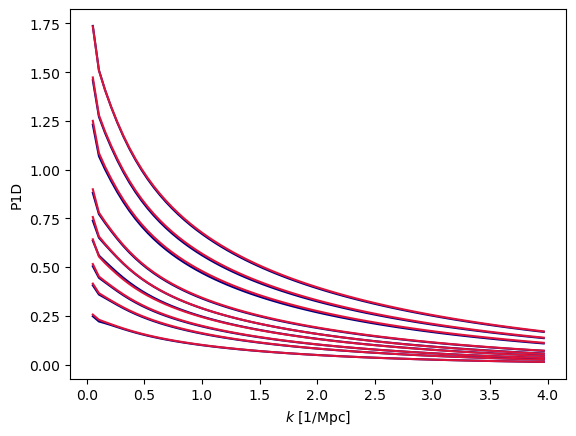

In [33]:
# test emulator by making simple plot
testing_data = archive.get_testing_data('nyx_central')

p1ds_true = np.zeros(shape=(11,75))
p1ds = np.zeros(shape=(11,75))

for m in range(11):
    if('kF_Mpc' not in testing_data[m]):
        continue
    p1d_true = testing_data[m]['p1d_Mpc']
    kMpc = testing_data[m]['k_Mpc']
    kMpc_test = kMpc[(kMpc>0) & (kMpc<4)]
    p1d_true = p1d_true[(kMpc>0) & (kMpc<4)]
    
    fit_p1d = poly_p1d.PolyP1D(kMpc_test,p1d_true, kmin_Mpc=1e-3,kmax_Mpc=4,deg=5)
    p1d_true = fit_p1d.P_Mpc(kMpc_test)
    
    p1d = emulator.emulate_p1d_Mpc(testing_data[m], kMpc_test)
    
    
    p1ds_true[m] = p1d_true
    p1ds[m] = p1d
    
    plt.plot(kMpc_test,p1d, label = 'Emulated', color = 'navy')
    plt.plot(kMpc_test,p1d_true, label = 'True', color = 'crimson')

    plt.xlabel(r'$k$ [1/Mpc]')
    plt.ylabel(r'P1D')

plt.show()

 /tmp/ipykernel_105245/894606714.py:26: RuntimeWarning:invalid value encountered in divide


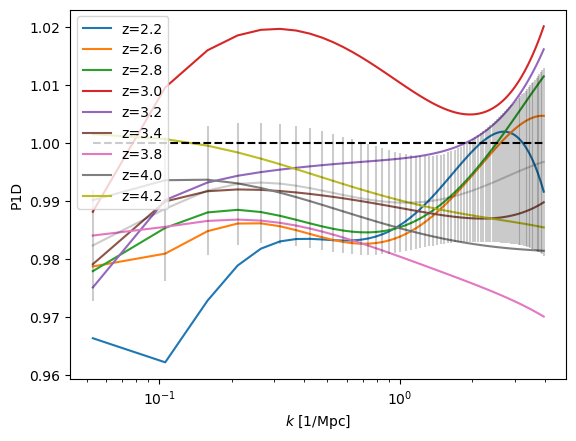

In [34]:
p1ds_true = np.zeros(shape=(11,75))
p1ds = np.zeros(shape=(11,75))

for m in range(11):
    if('kF_Mpc' not in testing_data[m]):
        continue
    p1d_true = testing_data[m]['p1d_Mpc']
    kMpc = testing_data[m]['k_Mpc']
    kMpc_test = kMpc[(kMpc>0) & (kMpc<4)]
    p1d_true = p1d_true[(kMpc>0) & (kMpc<4)]
    
    fit_p1d = poly_p1d.PolyP1D(kMpc_test,p1d_true, kmin_Mpc=1e-3,kmax_Mpc=4,deg=5)
    p1d_true = fit_p1d.P_Mpc(kMpc_test)
    
    p1d = emulator.emulate_p1d_Mpc(testing_data[m],kMpc_test)
    
    
    p1ds_true[m] = p1d_true
    p1ds[m] = p1d
    
    plt.plot(kMpc_test, p1d/p1d_true, label = 'z=' + str(np.round(testing_data[m]["z"], 2)))

    
plt.plot(kMpc_test, np.ones_like(kMpc_test), 'k--')

percent_error = p1ds/p1ds_true
plt.errorbar(kMpc_test, 
             np.nanmean(percent_error, axis=0), 
             np.nanstd(percent_error, axis=0), 
             color='k', alpha=0.2)
plt.xlabel(r'$k$ [1/Mpc]')
plt.ylabel(r'P1D')
plt.xscale('log')

plt.legend()